## 1. 🔍 Introduction

This report documents the training of the transformer-based chess engine model. While the architecture is described in detail elsewhere, we briefly outline the **outputs** of the model here as they determine the supervised **losses** used for training.

The model makes four distinct predictions for each board position:

```python
Y = TransformerOutput  # shape: (65, H)

eval_logits      = EvalHead(Y[0])         # shape: (3,)    # logits over {white win, draw, black win}
move_logits      = MoveHead(Y[1:])        # shape: (64, 7) # for each square: logits over piece types
check_logit      = InCheckHead(Y[1:])     # shape: (1,)    # binary logit: opponent in check
threat_logits    = ThreatHead(Y[1:])      # shape: (64, 2) # per square: threat flag (0/1)
```

Each prediction is supervised by a dedicated loss:

## 🎯 Loss Functions

Let:

- $\hat{p}_{\text{eval}} = \text{softmax}(\text{eval\_logits}) \in \mathbb{R}^3$
- $y_{\text{eval}} \in \{0, 1, 2\}$ denote the target result  
  (0 = black win, 1 = draw, 2 = white win)

---

### 1. **Evaluation Loss**

Cross-entropy loss over predicted game result:

$$
\mathcal{L}_{\text{eval}} = -\log \hat{p}_{\text{eval}}[y_{\text{eval}}]
$$

---

### 2. **Move Loss**

Each legal move $ l \in \{1, \dots, L\} $ is associated with a set of **changed squares** $ C_l \subset \{0, \dots, 63\} $, typically of size 2–4. These are the squares that are vacated or newly occupied after applying the move.

#### 🔢 Prediction

For each square $ i \in C_l $, we compute a **7-class softmax** over piece types from the move head logits:

- The prediction corresponds to the **piece class** at the square after the move (e.g., pawn, knight, ..., empty), not distinguishing between colors.
- The logits come from projecting the per-square embedding $ (64,H) \rightarrow (64,7) $, producing:
  $$
  z_{\text{move}}^{(i)} \in \mathbb{R}^7 \quad \text{(logits for piece class at square } i\text{)}
  $$

#### 🎯 Ground Truth

Let $ y_i \in \{0, \dots, 6\} $ be the true piece class at square $ i $ after the move is applied.

#### 🧮 Move Score

Aggregate the predicted logits for the target piece class across the changed squares to compute a score for each move:
$$
s_l = \frac{1}{|C_l|} \sum_{i \in C_l} z_{\text{move}}^{(i)}[y_i]
$$

#### 📊 Move Probabilities

Define the predicted probability distribution over all legal moves:
$$
\hat{p}_{\text{legal}} = \text{softmax}(s_1, \dots, s_L)
$$

#### 🧨 Move Loss

Use cross-entropy loss on the ground-truth move index $ l^* $:
$$
\mathcal{L}_{\text{move}} = -\log \hat{p}_{\text{legal}}[l^*]
$$

---

### 3. **In-Check Loss**

The in-check head predicts whether the *opponent king* will be in check **after** the ground-truth move is applied to the current position.

Let:

- $y_{\text{check}} \in \{0, 1\}$ be the ground-truth label (1 if the opponent is in check after the move)
- $\hat{p}_{\text{check}} \in [0, 1]$ be the predicted probability that the opponent is in check

**Note**: $\hat{p}_{\text{check}}$ is derived from the output of `check_logit`, specifically extracted at the opponent king’s square.

The loss is the binary cross-entropy:

$$
\mathcal{L}_{\text{check}} = \text{BCE}(\hat{p}_{\text{check}}, y_{\text{check}})
$$

---

### 4. **Threat Loss**

The threat head predicts whether each square will become threatened *as a result* of the ground-truth move.

Let:

- $y_{\text{threat}}^{(i)} \in \{0, 1\}$ indicate whether square $i$ is threatened after the move
- $\hat{p}_{\text{threat}}^{(i)} \in [0, 1]$ be the predicted probability from the `threat_logits` head

The loss is computed as binary cross-entropy over squares whose threat status changes as a result of the move:

$$
\mathcal{L}_{\text{threat}} = \frac{1}{|S|} \sum_{i \in S} \text{BCE}(\hat{p}_{\text{threat}}^{(i)}, y_{\text{threat}}^{(i)})
$$

Where $S$ is the set of squares whose threat status has changed.

---

## 🔧 Total Loss

The total loss is a weighted sum:

$$
\mathcal{L}_{\text{total}} = 
\lambda_{\text{eval}} \mathcal{L}_{\text{eval}} +
\lambda_{\text{move}} \mathcal{L}_{\text{move}} +
\lambda_{\text{check}} \mathcal{L}_{\text{check}} +
\lambda_{\text{threat}} \mathcal{L}_{\text{threat}}
$$

Weights $\lambda_i$ are set by config and used to control the emphasis of each objective.

## 2. ⚙️ Configuration Summary

This section summarizes the key hyperparameters and settings used in training.

### 🧪 Data

- **Dataset**: 22M board positions (with legal moves and game outcomes)
- **Train / Val Split**: 90% train, 10% validation
- **Batch Size**: 512
- **Num Workers**: 2
- **Pin Memory**: `True`, Prefetch Factor: 2

### 🧠 Model

- **Architecture**: Transformer-based encoder
- **Embedding Dimension**: 128
- **Heads / Layers**: 8 heads, 12 layers
- **MLP Ratio**: 4
- **Dropout**: 0.1
- **Recycles**: 4 passes through the model
- **Feature Dim**: 21 input channels

### 🎯 Loss Weights

- `λ_prob_eval` = 1.0  
- `λ_move` = 1.0  
- `λ_threat` = 0.2  
- `λ_check` = 0.1  
- **Move Weighting**: Uniform (no per-move weighting)

### 🛠️ Training

- **Optimizer**: AdamW  
- **Learning Rate**: 0.0023  
- **Weight Decay**: 0.01  
- **Scheduler**: Cosine annealing with `T_max = total_training_steps`
- **Max Epochs**: 30
- **Precision**: bfloat16 mixed precision
- **Device**: A100 GPU

## 3. 📚 Data Overview

The training data was sourced from [Lichess PGN database](https://database.lichess.org/), which provides large-scale collections of chess games. I used February 2025 data games.

To ensure high-quality examples, we applied the following filters:

- Both players must be rated **above 2400**.
- Games must be **at least 5 minutes per side** to exclude low-effort blitz games.

This filtering process yielded:

- **22,596 games**
- **2,370,238 board positions**
- Positions are divided into **23 shards** (shards 0–22), each containing exactly **1,000 games** and weighing **~500–700MB** after processing.

### 🧹 Data Processing Pipeline

1. **Filtering**:
   - Scripts `pgn_filtering.py` and `pgn_time_filtering.py` were used to apply rating and time controls filters to raw PGN files. The `pgn` shards in data/shards300_small are already filtered.

2. **Parsing**:
   - `position_parsing.py` converts filtered PGN games into a structured batch format:
     - Board input tensors
     - Labels for move targets, evaluation result, in-check flag, threats, etc.
     - All the tensors are saved in `int8` or `uint8` type to improve efficiency.   

3. **Final Packaging**:
   - `convert_to_stacked_shards.py` collects and compresses parsed batches into final `.pt` tensor files.
   - This significantly accelerates data loading during training.

Each shard in its final form contains all required inputs and targets for model training, allowing efficient streaming from disk.

> 🔧 A wrapper script that automates this multi-stage processing for all shards is under consideration for simplifying dataset regeneration.

In [ ]:
# parse_shards.py

import subprocess

def parse_shards(start=0, end=23):
    for i in range(start, end):
        input_file = f"data/shards300_small/shard_{i}.pgn"
        output_file = f"data/shards300_small/positions{i}.pt"
        command = [
            "python3", "chessengine/preprocessing/position_parsing.py",
            "--input", input_file,
            "--output", output_file
        ]
        print(f"🔹 Parsing shard {i}...")
        result = subprocess.run(command)
        if result.returncode != 0:
            print(f"❌ Failed to parse shard {i}")

# Example usage:
# parse_shards(20, 23)

In [ ]:
from data.convert_to_stacked_shards import convert_shard_format

input_path = "data/shards300_small"
output_path = "data/stacked_shards"
convert_shard_format(input_path, output_path)

### Legal moves statistics

We use only a single shard to get the distribution. 

/Users/itamarshamir/Documents/code/chess_engine/chessengine/model/dataclass.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shard = torch.load(path, map_location="cpu")

Loaded data/stacked_shards/positions10.pt in 0.17s
Global max legal_moves width: 67
Train set size: 99426
Validation set size: 0


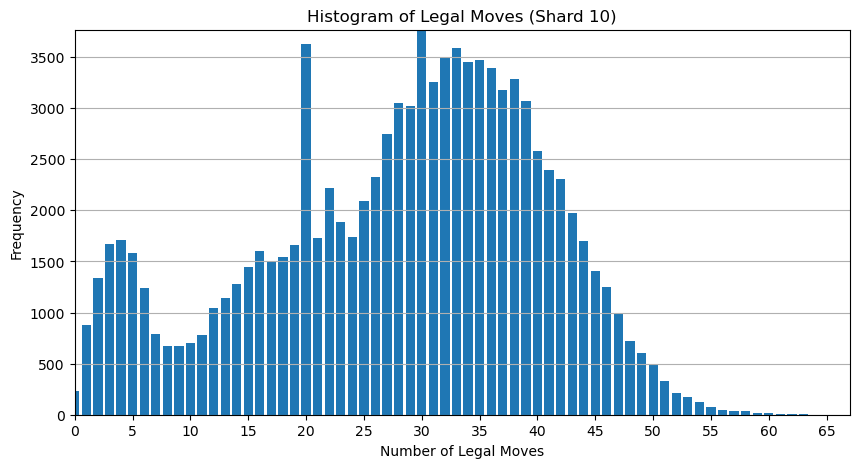

In [1]:
# 📊 Legal Move Histogram Analysis from a Single Shard

import torch
import matplotlib.pyplot as plt
import numpy as np
from chessengine.model.datamodule import ChessDataModule

# Path to the shard to analyze
test_path = "data/stacked_shards/positions10.pt"

# Minimal config for dataloader
config = {
    'dataloader': {
        "batch_size": 1,
        "num_workers": 0,
        "persistent_workers": False
    },
    'data_split': 0.0,
    'train': {'device': 'cpu'}
}

# Load data using the existing DataModule
dm = ChessDataModule(config, [test_path], OVERFIT=False)
dm.setup()
loader = dm.train_dataloader()

# Build histogram of legal move counts
legal_moves_histogram = {}
for batch in loader:
    _, labels = batch
    num_moves = labels["legal_moves"].shape[-1]
    legal_moves_histogram[num_moves] = legal_moves_histogram.get(num_moves, 0) + 1

# Sort the histogram for plotting
legal_moves_histogram = dict(sorted(legal_moves_histogram.items()))
keys = list(legal_moves_histogram.keys())
values = list(legal_moves_histogram.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(keys, values)
plt.xlabel("Number of Legal Moves")
plt.ylabel("Frequency")
plt.title("Histogram of Legal Moves (Shard 10)")
plt.xticks(np.arange(min(keys), max(keys)+1, 5))
plt.xlim(min(keys), max(keys))
plt.ylim(0, max(values) + 10)
plt.grid(axis='y')
plt.show()

### Comments:

- 20 is the number of legal moves for the openning position (2 moves for each of 8 pawns and 2 knights) for both white and black, so occurs at least twice in every game. Other positions in the openning phase have similar numbers which possibly accounts for the slight "bump" around 16-24. Note the frequency is about half than that of $l = 20$.

- For standard positions we have ~ 30-35 moves on average. This number collapses sharply for positions in check where the number of legal moves is ~ 5 or less. Hence the very clear bimodal behaviour of the distribution. 

## 4. ✅ Sanity Checks at Initialization

To validate that the model behaves sensibly before training, we compare several loss values and accuracy metrics at **initialization** to their **expected values** under the assumption that the model assigns **uniform probabilities to all legal moves**.

This serves as a basic sanity check for the loss functions and can highlight issues such as broken data pipelines or ill-scaled logits.

---

### 🔢 Assumption: Uniform Random Policy

We assume the model assigns **equal probability** to all legal moves in a position:
- If a position has $m$ legal moves, each has probability $1/m$.
- If $m < k$ (e.g. top-5 accuracy), we treat top-$k$ accuracy as 1 by definition.

Let $P(m)$ be the **empirical distribution** (probability mass function) over the number of legal moves in the dataset, estimated from a representative shard.

---

### 🎯 Metrics and Expected Values

#### **1. Move Loss**
The expected move loss is the expected negative log-probability of the ground truth move under uniform sampling:

$$
\mathbb{E}[\mathcal{L}_{\text{move}}] = -\sum_m P(m) \cdot \log\left(\frac{1}{m}\right)
= \sum_m P(m) \cdot \log(m)
$$

This corresponds to the expected **entropy** of the uniform distribution over legal moves.

---

#### **2. Top-k Accuracy and Top-k probability**

Let $k$ be 1, 3, or 5. The expected top-$k$ accuracy is: (i.e. the correct move is sampled uniformly from all legal moves)

$$
\text{Top-k Acc} = \sum_{m=1}^{\infty} P(m) \cdot \min\left(1, \frac{k}{m}\right)
$$

This is the expected fraction of times the correct move would fall into a uniformly sampled top-$k$ list.

Note that top-k probability is identical when all moves have the same probability. 

---

#### **3. True Probability**

This is the predicted probability assigned to the correct move (same expression as move loss, but in linear space):

$$
\mathbb{E}[\text{TrueProb}] = \sum_{m>0} P(m) \cdot \frac{1}{m}
$$

---

#### **4. Eval Loss (3-class classification)**

If evaluation logits are untrained, softmax is uniform: $\hat{p}_{\text{eval}} = (1/3, 1/3, 1/3)$, so:

$$
\mathbb{E}[\mathcal{L}_{\text{eval}}] = -\log\left(\frac{1}{3}\right) \approx 1.0986
$$

In [4]:
import math

# Make sure legal_moves_histogram is already computed from earlier
# Format: {num_legal_moves: count, ...}
# Normalize to a probability distribution
total_positions = sum(legal_moves_histogram.values())
move_probs = {m: count / total_positions for m, count in legal_moves_histogram.items()}

# Expected values under uniform random prediction
expected_top1 = 0.0
expected_top3 = 0.0
expected_top5 = 0.0
expected_true_prob = 0.0
expected_move_loss = 0.0

for m, p in move_probs.items():
    if m == 0:
        continue
    expected_true_prob += p * (1 / m)
    expected_top1     += p * (1 / m)
    expected_top3     += p * min(3, m) / m
    expected_top5     += p * min(5, m) / m
    expected_move_loss += p * math.log(m)  # since loss = -log(1/m)

# Print results
print("Expected metrics under uniform random prediction:")
print(f"Top-1 Accuracy:     {expected_top1 * 100:.2f}%")
print(f"Top-3 Accuracy:     {expected_top3 * 100:.2f}%")
print(f"Top-5 Accuracy:     {expected_top5 * 100:.2f}%")
print(f"True Prob (avg 1/m): {expected_true_prob:.4f}")
print(f"Expected Move Loss: {expected_move_loss:.4f} nats   ({expected_move_loss / math.log(2):.4f} bits)")

Expected metrics under uniform random prediction:
Top-1 Accuracy:     6.63%
Top-3 Accuracy:     17.46%
Top-5 Accuracy:     26.06%
True Prob (avg 1/m): 0.0663
Expected Move Loss: 3.1496 nats   (4.5439 bits)


### Losses and Metrics before training

- Some of the metrics are probabilities and some are percentages. 

- They match very nicely with the expected scores computed above for uniform distribution over all legal moves (taking into account the distribution of number of legal moves).

![Caption for the image](Before_training.png)

## 5. Training

- We used a single A100 (on google Colab)  
- Batch size of 512 
- 30 epochs, each taking just over 8 minutes. 

### Results

- 70% of legal moves are assigned less than 1% chance 
- The 3 top moves the engine favors account for 74% of predicted probability. The top-5 account for 85%
- The ground truth move appeared in the top-3 prediction 72.7% and 84% in the top-5
- The engine chose the ground truth move 44.4%
- The ground truth move was assigned 32.5% on average (even if not necessarily top move)

![Caption for the image](After_base_training.png)

### Validation curves

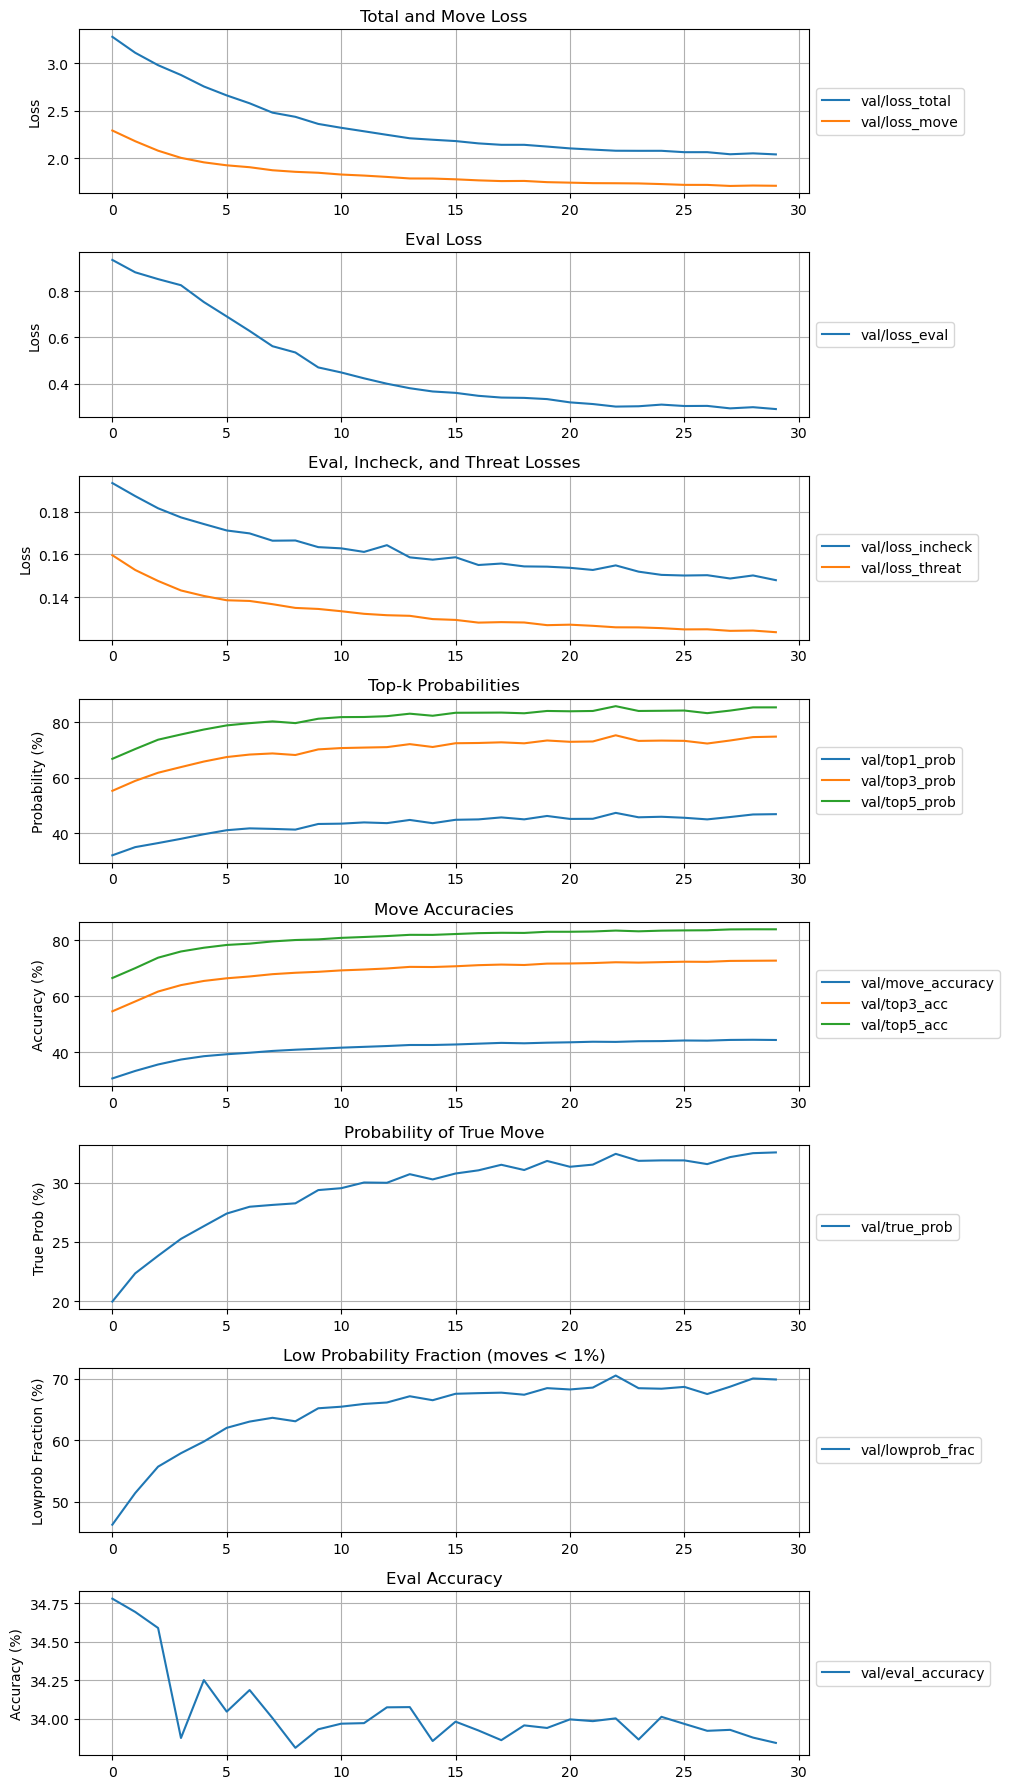

In [1]:
from plot_tensorboard_curves import plot_tensorboard_metrics

# Plotting the curves
plot_tensorboard_metrics("lightning_logs/BaseModel", tag_filter="val/", figsize=(12,18), steps_per_epoch=4167)